# Setup

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import logging
import tpvalidator.mcprod.workspace as workspace
import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn

from rich import print
from tpvalidator.utilities import temporary_log_level, subplot_autogrid, pandas_backend
from tpvalidator.histograms import uproot_hist_mean_std

from collections import OrderedDict

# Code

In [ ]:
from typing import Tuple, Optional, Union, Sequence, Dict, List
from rich.table import Table
from tpvalidator.mcprod.geometry import FDVDGeometry_1x6x8


def make_rates_table( datasets : Dict[str,workspace.TriggerPrimitivesWorkspace], preselection: str = '', per:str='chan', title: str='', ro_win_len: int=8500) -> Table:
    """
    Calculates the TP rates of each workspace in the dataset list.
    The rate is calculated over the chosen unit specified by the `per` argument: channel, crp, tpc or detector.
    The rates are displayed per unit and per view.

    If a preselection is specified, this is applied to all datasets before the rate calculation.
    The readout window lenght, needed for the rate estimate, is passed as argument.
    """
    
    # Constants : move them somewhere else
    sampling_period = 0.5e-6

    num_el_map = {
        'chan' : lambda v: FDVDGeometry_1x6x8.crp_num_chans_by_view_sim(v)*FDVDGeometry_1x6x8.num_crps,
        'crp' : lambda _: FDVDGeometry_1x6x8.num_crps,
        'tpc' : lambda _: FDVDGeometry_1x6x8.num_tpcs,
        'det' : lambda _: 1,
    }
    
    num_el = num_el_map[per]

    t = Table('sample', 'time', 'U', 'V', 'X', title=title)
    for s, ws in datasets.items():
        num_ev = ws.num_events
        total_time = num_ev*ro_win_len*sampling_period
        row = [s, f'{total_time:.3f} s']
        tps_sel = ws.tps.query(preselection) if preselection else ws.tps
        for v in range(3):
            num_els = num_el(v)
            noise_rate = len(tps_sel.query(f'readout_view == {v}'))/total_time/num_els
            row += [f'{noise_rate:.2f} Hz']
        t.add_row(*row)
    return t

In [4]:
def make_vd_rates_table_2(datasets : Dict[str,pd.DataFrame], num_events, preselection: str = '', per:str='chan', title: str='', ro_win_len: int=8500, sampling_period=5e-6) -> Table:

    num_el_map = {
        'chan' : lambda v: FDVDGeometry_1x6x8.crp_num_chans_by_view_sim(v)*FDVDGeometry_1x6x8.num_crps,
        'crp' : lambda _: FDVDGeometry_1x6x8.num_crps,
        'tpc' : lambda _: FDVDGeometry_1x6x8.num_tpcs,
        'det' : lambda _: 1,
    }

    num_el = num_el_map[per]

    t = Table('sample', 'time', 'U', 'V', 'X', title=title)
    for s, df in datasets.items():
        num_ev = num_events
        total_time = num_ev*ro_win_len*sampling_period
        row = [s, f'{total_time:.3f} s']
        tps_sel = df.query(preselection) if preselection else df
        for v in range(3):
            num_els = num_el(v)
            noise_rate = len(tps_sel.query(f'readout_view == {v}'))/total_time/num_els
            row += [f'{noise_rate:.2f} Hz']
        t.add_row(*row)
    return t

# Data

In [5]:
from pathlib import Path
pre_prod_dir = Path('../../data/vd/pre_prod/')

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    mu_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_muminus_hist.root')

mu_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_muminus.root')
print(mu_ws.info)

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    em_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_eminus_hist.root')

em_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_eminus.root')
print(em_ws.info)

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    gm_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_gamma_hist.root')

gm_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_gamma.root')
print(gm_ws.info)


with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    ar39_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_ar39_hist.root')

ar39_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_ar39.root')

print(ar39_ws.info)


with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    rad_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_radiols_hist.root')
rad_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_radiols.root')

print(rad_ws.info)


datasets = {
    'e-minus': em_ws,
    'gamma': gm_ws,
    'mu-minus': mu_ws,
    'ar39': ar39_ws,
    'radiols': rad_ws
}


{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

In [6]:
safe_samples_cut = '(sample_peak > 100 & sample_peak < 8100)'

# TP Rates

## Per detector channel

For conparison with HD

In [7]:
print(make_rates_table(datasets, f'bt_is_signal == 0 & {safe_samples_cut}', ro_win_len=8000, title='noise TP rates'))
print(make_rates_table(datasets, f'bt_is_signal == 1 & {safe_samples_cut}', ro_win_len=8000, title='signal TP rates'))

                   noise TP rates                    
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time    ┃ U       ┃ V        ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 0.74 Hz │ 0.72 Hz  │ 0.30 Hz │
│ gamma    │ 0.400 s │ 0.74 Hz │ 0.72 Hz  │ 0.30 Hz │
│ mu-minus │ 0.400 s │ 0.71 Hz │ 0.73 Hz  │ 0.32 Hz │
│ ar39     │ 0.400 s │ 0.94 Hz │ 2.17 Hz  │ 0.42 Hz │
│ radiols  │ 0.400 s │ 9.81 Hz │ 14.60 Hz │ 3.97 Hz │
└──────────┴─────────┴─────────┴──────────┴─────────┘

                    signal TP rates                    
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ sample   ┃ time    ┃ U        ┃ V        ┃ X        ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 0.42 Hz  │ 0.38 Hz  │ 0.47 Hz  │
│ gamma    │ 0.400 s │ 0.36 Hz  │ 0.35 Hz  │ 0.43 Hz  │
│ mu-minus │ 0.400 s │ 0.33 Hz  │ 0.33 Hz  │ 0.39 Hz  │
│ ar39     │ 0.400 s │ 20.85 Hz │ 10.08 Hz │ 32.97 Hz │
│ radiols  │ 0.400 s │ 54.30 Hz │ 32.07 Hz │ 76.66 Hz │
└──────────┴─────────┴──────────┴──────────┴──────────┘

## Per CRP

For comparison with HD. Each CRP observes a LAr volume equivalent to an APA

In [8]:
print(make_rates_table(datasets, f'bt_is_signal == 0 & {safe_samples_cut}', per='crp', ro_win_len=8000, title='noise TP rates'))
print(make_rates_table(datasets, f'bt_is_signal == 1 & {safe_samples_cut}', per='crp', ro_win_len=8000, title='signal TP rates'))

                        noise TP rates                         
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ sample   ┃ time    ┃ U           ┃ V           ┃ X          ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 841.04 Hz   │ 818.33 Hz   │ 351.67 Hz  │
│ gamma    │ 0.400 s │ 846.67 Hz   │ 823.12 Hz   │ 345.62 Hz  │
│ mu-minus │ 0.400 s │ 817.50 Hz   │ 829.58 Hz   │ 368.54 Hz  │
│ ar39     │ 0.400 s │ 1073.75 Hz  │ 2486.67 Hz  │ 486.67 Hz  │
│ radiols  │ 0.400 s │ 11227.29 Hz │ 16702.50 Hz │ 4637.29 Hz │
└──────────┴─────────┴─────────────┴─────────────┴────────────┘

                        signal TP rates                         
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ sample   ┃ time    ┃ U           ┃ V           ┃ X           ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 477.08 Hz   │ 438.54 Hz   │ 553.54 Hz   │
│ gamma    │ 0.400 s │ 417.50 Hz   │ 397.29 Hz   │ 503.96 Hz   │
│ mu-minus │ 0.400 s │ 379.17 Hz   │ 380.42 Hz   │ 456.04 Hz   │
│ ar39     │ 0.400 s │ 23852.50 Hz │ 11529.79 Hz │ 38512.29 Hz │
│ radiols  │ 0.400 s │ 62120.21 Hz │ 36684.17 Hz │ 89534.79 Hz │
└──────────┴─────────┴─────────────┴─────────────┴─────────────┘

## Per CRP with SOT cut

As before, after including the `samples_over_threshold > 8` for rejection of Ar39 signals

In [146]:
print(make_rates_table(datasets, f'bt_is_signal == 0 & {safe_samples_cut} & samples_over_threshold > 8', per='crp', ro_win_len=8000, title='noise TP rates'))
print(make_rates_table(datasets, f'bt_is_signal == 1 & {safe_samples_cut} & samples_over_threshold > 8', per='crp', ro_win_len=8000, title='signal TP rates'))

                    noise TP rates                     
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time    ┃ U        ┃ V         ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 0.42 Hz  │ 1.67 Hz   │ 0.00 Hz │
│ gamma    │ 0.400 s │ 0.42 Hz  │ 1.67 Hz   │ 0.00 Hz │
│ mu-minus │ 0.400 s │ 0.83 Hz  │ 1.04 Hz   │ 0.00 Hz │
│ ar39     │ 0.400 s │ 0.00 Hz  │ 0.00 Hz   │ 0.00 Hz │
│ radiols  │ 0.400 s │ 22.29 Hz │ 314.58 Hz │ 0.42 Hz │
└──────────┴─────────┴──────────┴───────────┴─────────┘

                       signal TP rates                        
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ sample   ┃ time    ┃ U         ┃ V           ┃ X           ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 286.04 Hz │ 323.13 Hz   │ 435.62 Hz   │
│ gamma    │ 0.400 s │ 250.21 Hz │ 293.96 Hz   │ 392.92 Hz   │
│ mu-minus │ 0.400 s │ 216.04 Hz │ 277.71 Hz   │ 341.46 Hz   │
│ ar39     │ 0.400 s │ 0.00 Hz   │ 55.83 Hz    │ 633.54 Hz   │
│ radiols  │ 0.400 s │ 971.04 Hz │ 12745.00 Hz │ 16162.71 Hz │
└──────────┴─────────┴───────────┴─────────────┴─────────────┘

# Background rates and spectra per radiological process

In [ ]:
# Create a TP preselection - only TPs with peak within the range where backtracking works

rad_sel = snn.TPSignalNoisePreSelection(rad_ws.tps.query(safe_samples_cut))

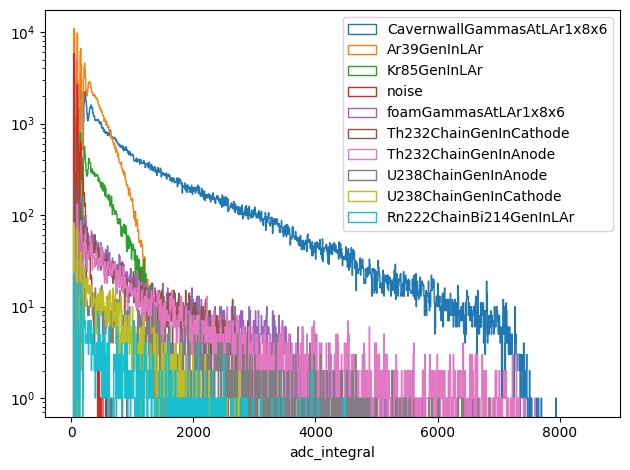

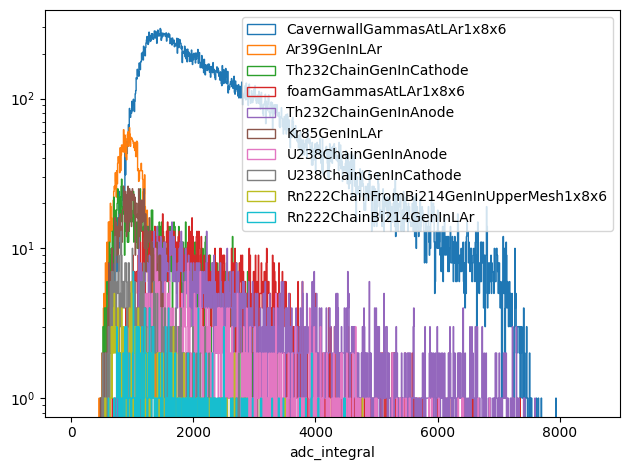

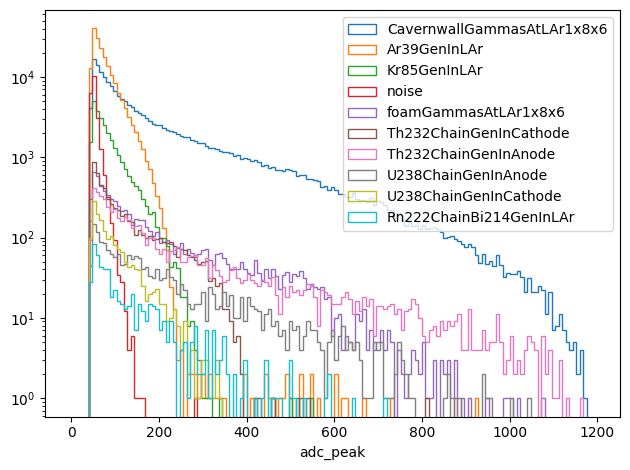

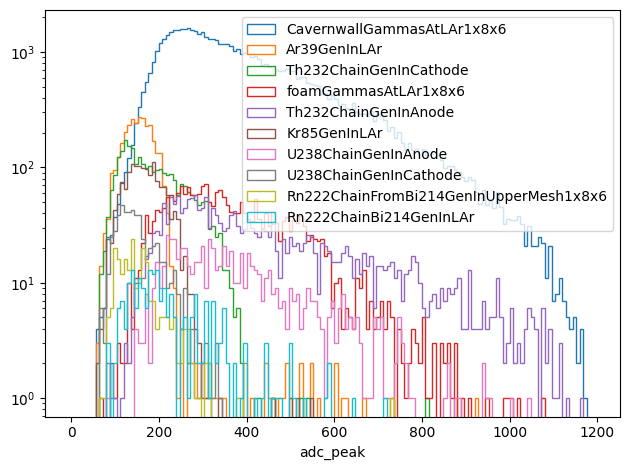

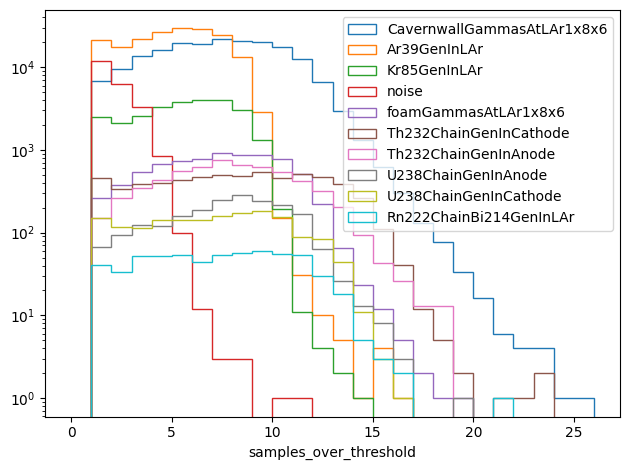

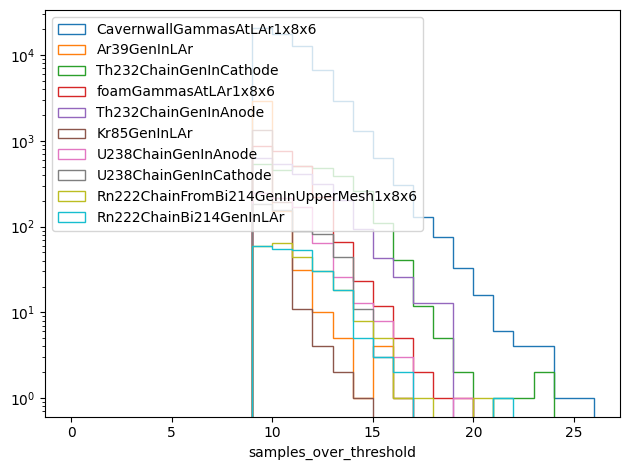

In [ ]:
# Plot rates distributions for the top backgrounds

def plot_rates_by_source(tps, var='adc_integral', binsize=8):

    num_bkg = 10
    tps_by_gen = sorted([(n,df) for n,df in tps.groupby('bt_generator_name')], reverse=True, key=lambda x: len(x[1]))
    top_by_gen = tps_by_gen[:num_bkg]

    # print(top_by_gen)
    bin_max = max([df[var].max() for _, df in top_by_gen])

    # print(bin_max)
    bins=list(range(0, int(bin_max), binsize))

    fig, ax = plt.subplots()
    for n,df in top_by_gen:
        ax.hist(df[var], bins=bins, histtype='step', label=n if n else 'noise')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel(var)
    fig.tight_layout()
    return fig

ro_view = 2
var = 'adc_integral'
fig = plot_rates_by_source(rad_sel.all_by_view[ro_view], var=var)
fig = plot_rates_by_source(rad_sel.all_by_view[ro_view].query('samples_over_threshold > 8'), var=var)
var = 'adc_peak'
fig = plot_rates_by_source(rad_sel.all_by_view[ro_view], var=var)
fig = plot_rates_by_source(rad_sel.all_by_view[ro_view].query('samples_over_threshold > 8'), var=var)
var = 'samples_over_threshold'
fig = plot_rates_by_source(rad_sel.all_by_view[ro_view], var=var, binsize=1)
fig = plot_rates_by_source(rad_sel.all_by_view[ro_view].query('samples_over_threshold > 8'), var=var, binsize=1)


## Rates per background process process

In [ ]:
# Split the background sample by generator name, into a collection of dataframes
rad_tps_by_gen = sorted([(n if n else 'Noise',df) for n,df in rad_sel.all.groupby('bt_generator_name')], reverse=True, key=lambda x: len(x[1]))

In [ ]:
# Print rates of each background by readout view
# Without cuts and applying the SOT cut to reject Ar39
print(make_vd_rates_table_2(OrderedDict(rad_tps_by_gen), 100, per='crp', title='Rates per CRP'))
print(make_vd_rates_table_2(OrderedDict(rad_tps_by_gen), 100, 'samples_over_threshold>8', per='crp', ro_win_len=8000, title='Rates per CRP (SOT > 8)'))

                                       Rates per CRP                                       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ sample                                 ┃ time    ┃ U          ┃ V          ┃ X          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ CavernwallGammasAtLAr1x8x6             │ 4.250 s │ 2818.75 Hz │ 1839.67 Hz │ 3729.69 Hz │
│ Ar39GenInLAr                           │ 4.250 s │ 2261.45 Hz │ 1095.49 Hz │ 3637.71 Hz │
│ Noise                                  │ 4.250 s │ 1056.69 Hz │ 1572.00 Hz │ 436.45 Hz  │
│ Kr85GenInLAr                           │ 4.250 s │ 364.98 Hz  │ 219.41 Hz  │ 529.27 Hz  │
│ foamGammasAtLAr1x8x6                   │ 4.250 s │ 114.02 Hz  │ 73.18 Hz   │ 149.65 Hz  │
│ Th232ChainGenInCathode                 │ 4.250 s │ 89.10 Hz   │ 80.27 Hz   │ 122.71 Hz  │
│ Th232ChainGenInAnode                   │ 4.250 s │ 95.82 Hz   │ 64.00 Hz   │ 118.80 Hz  │
│ U238ChainGenInAnode                    │ 4.250 s │ 31.18 Hz   │ 21.80 Hz   │ 39.67 Hz   │
│ U238ChainGenInCathode                  │ 4.250 s │ 22.57 Hz   │ 19.49 Hz   │ 33.55 Hz   │
│ Rn222ChainBi214GenInLAr                │ 4.250 s │ 9.47 Hz    │ 7.96 Hz    │ 12.02 Hz   │
│ Rn222ChainFromBi214GenInUpperMesh1x8x6 │ 4.250 s │ 8.73 Hz    │ 7.69 Hz    │ 11.88 Hz   │
│ K40GenInAnode                          │ 4.250 s │ 8.24 Hz    │ 5.80 Hz    │ 9.33 Hz    │
│ Rn220ChainFromPb212GenInUpperMesh1x8x6 │ 4.250 s │ 6.84 Hz    │ 6.08 Hz    │ 9.10 Hz    │
│ Rn220ChainPb212GenInLAr                │ 4.250 s │ 4.59 Hz    │ 4.02 Hz    │ 5.20 Hz    │
│ K40GenInCathode                        │ 4.250 s │ 3.98 Hz    │ 3.35 Hz    │ 5.41 Hz    │
│ Rn222ChainFromBi210GenInUpperMesh1x8x6 │ 4.250 s │ 1.82 Hz    │ 1.35 Hz    │ 3.25 Hz    │
│ Rn222ChainPb214GenInLAr                │ 4.250 s │ 1.98 Hz    │ 1.04 Hz    │ 3.20 Hz    │
│ K42From42ArGenInUpperMesh1x8x6         │ 4.250 s │ 1.41 Hz    │ 1.37 Hz    │ 1.73 Hz    │
│ Rn222ChainPo218GenInLAr                │ 4.250 s │ 0.59 Hz    │ 0.08 Hz    │ 1.63 Hz    │
│ Rn222ChainRn222GenInLAr                │ 4.250 s │ 0.12 Hz    │ 0.06 Hz    │ 1.57 Hz    │
│ Rn222ChainFromPb214GenInUpperMesh1x8x6 │ 4.250 s │ 0.49 Hz    │ 0.20 Hz    │ 0.88 Hz    │
│ Ar42GenInLAr                           │ 4.250 s │ 0.29 Hz    │ 0.12 Hz    │ 0.39 Hz    │
│ K42From42ArGenInLAr                    │ 4.250 s │ 0.20 Hz    │ 0.20 Hz    │ 0.18 Hz    │
└────────────────────────────────────────┴─────────┴────────────┴────────────┴────────────┘

                                 Rates per CRP (SOT > 8)                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ sample                                 ┃ time    ┃ U        ┃ V          ┃ X          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ CavernwallGammasAtLAr1x8x6             │ 4.000 s │ 71.38 Hz │ 1114.38 Hz │ 1309.83 Hz │
│ Ar39GenInLAr                           │ 4.000 s │ 0.15 Hz  │ 6.56 Hz    │ 64.60 Hz   │
│ Noise                                  │ 4.000 s │ 2.23 Hz  │ 31.46 Hz   │ 0.04 Hz    │
│ Kr85GenInLAr                           │ 4.000 s │ 0.06 Hz  │ 4.75 Hz    │ 32.02 Hz   │
│ foamGammasAtLAr1x8x6                   │ 4.000 s │ 1.40 Hz  │ 43.15 Hz   │ 51.75 Hz   │
│ Th232ChainGenInCathode                 │ 4.000 s │ 14.62 Hz │ 32.15 Hz   │ 58.25 Hz   │
│ Th232ChainGenInAnode                   │ 4.000 s │ 5.58 Hz  │ 42.31 Hz   │ 47.73 Hz   │
│ U238ChainGenInAnode                    │ 4.000 s │ 0.56 Hz  │ 12.92 Hz   │ 15.42 Hz   │
│ U238ChainGenInCathode                  │ 4.000 s │ 0.81 Hz  │ 4.42 Hz    │ 11.83 Hz   │
│ Rn222ChainBi214GenInLAr                │ 4.000 s │ 0.35 Hz  │ 2.71 Hz    │ 4.75 Hz    │
│ Rn222ChainFromBi214GenInUpperMesh1x8x6 │ 4.000 s │ 0.62 Hz  │ 2.06 Hz    │ 4.85 Hz    │
│ K40GenInAnode                          │ 4.000 s │ 0.02 Hz  │ 3.33 Hz    │ 4.33 Hz    │
│ Rn220ChainFromPb212GenInUpperMesh1x8x6 │ 4.000 s │ 0.90 Hz  │ 2.54 Hz    │ 4.48 Hz    │
│ Rn220ChainPb212GenInLAr                │ 4.000 s │ 0.35 Hz  │ 1.83 Hz    │ 2.58 Hz    │
│ K40GenInCathode                        │ 4.000 s │ 0.02 Hz  │ 0.56 Hz    │ 2.21 Hz    │
│ Rn222ChainFromBi210GenInUpperMesh1x8x6 │ 4.000 s │ 0.00 Hz  │ 0.00 Hz    │ 0.23 Hz    │
│ Rn222ChainPb214GenInLAr                │ 4.000 s │ 0.00 Hz  │ 0.02 Hz    │ 0.15 Hz    │
│ K42From42ArGenInUpperMesh1x8x6         │ 4.000 s │ 0.21 Hz  │ 0.62 Hz    │ 1.06 Hz    │
│ Rn222ChainPo218GenInLAr                │ 4.000 s │ 0.00 Hz  │ 0.02 Hz    │ 0.02 Hz    │
│ Rn222ChainRn222GenInLAr                │ 4.000 s │ 0.00 Hz  │ 0.02 Hz    │ 0.02 Hz    │
│ Rn222ChainFromPb214GenInUpperMesh1x8x6 │ 4.000 s │ 0.00 Hz  │ 0.00 Hz    │ 0.00 Hz    │
│ Ar42GenInLAr                           │ 4.000 s │ 0.00 Hz  │ 0.02 Hz    │ 0.00 Hz    │
│ K42From42ArGenInLAr                    │ 4.000 s │ 0.06 Hz  │ 0.12 Hz    │ 0.15 Hz    │
└────────────────────────────────────────┴─────────┴──────────┴────────────┴────────────┘

# TP properties in signal samples

In [153]:

dataset_sel = {
    n: snn.TPSignalNoisePreSelection(df.tps.query(safe_samples_cut)) for n, df in datasets.items()
}

(0.0, 25.0)

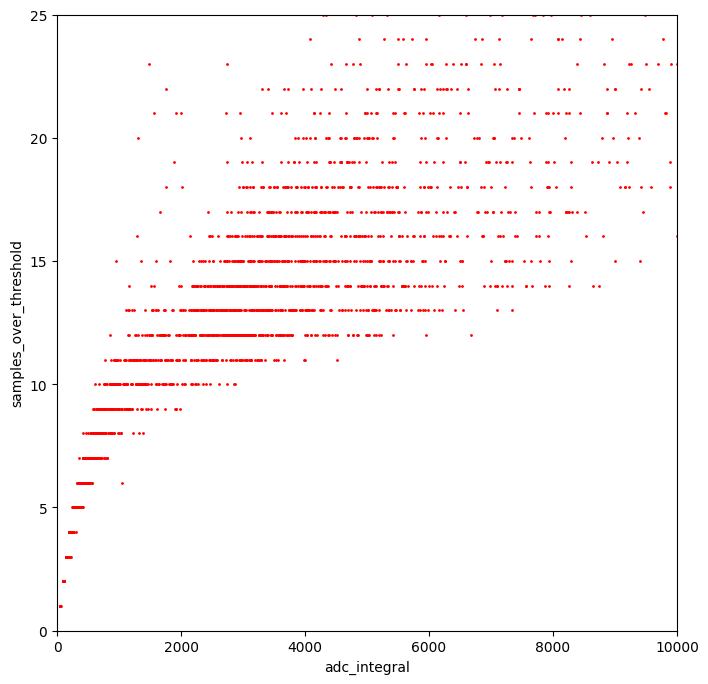

In [154]:
fix, ax = plt.subplots(figsize=(8,8))

size=1
x_name='adc_integral'
dataset_sel['e-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='red')
# dataset_sel['mu-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='green')
# dataset_sel['gamma'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='orange')
# dataset_sel['radiols'].sig_view_2.query('bt_generator_name != "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='green')
# dataset_sel['radiols'].sig_view_2.query('bt_generator_name == "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='blue')


ax.set_xlim(left=0, right=10000)
ax.set_ylim(bottom=0, top=25)



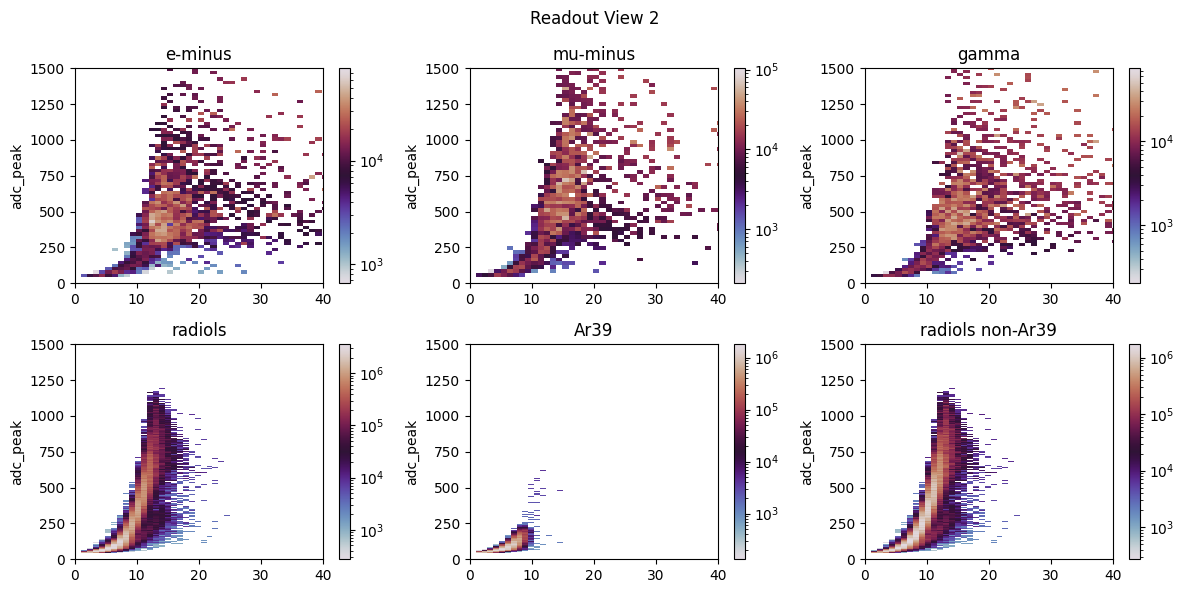

In [88]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2,3, figsize=(12,6))

size=1
x_name='samples_over_threshold'
x_range  = 0,40
y_name='adc_peak'
y_range  = 0,1500
cmap='twilight'
weights = 'adc_integral'
cut=''
v = 2

# dataset_sel['e-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='red')
# dataset_sel['mu-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='green')
# dataset_sel['gamma'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='orange')
# dataset_sel['radiols'].sig_view_2.query('bt_generator_name != "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='green')
# dataset_sel['radiols'].sig_view_2.query('bt_generator_name == "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='blue')


def plot_me(ax, sample, sample_query: str = None, title: str = None):
    """
    Helper function
    """
    df = dataset_sel[sample].sig_by_view[v]
    title = title if title else sample
    
    # Trim the dataframe
    for c in [sample_query, cut]:
        df = df.query(c) if c else df

    w = df[weights] if weights else None

    bins=(df[x_name].max(), 200)
    h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

    fig.colorbar(h[3], ax=ax)

    ax.set_title(title)
    ax.set_ylim(y_range)
    ax.set_ylabel(y_name)
    ax.set_xlim(x_range)

plot_me(axes[0][0], 'e-minus')
plot_me(axes[0][1], 'mu-minus')
plot_me(axes[0][2], 'gamma')
plot_me(axes[1][0], 'radiols')
plot_me(axes[1][1], 'radiols', 'bt_generator_name == "Ar39GenInLAr"', title='Ar39')
plot_me(axes[1][2], 'radiols', 'bt_generator_name != "Ar39GenInLAr"', 'radiols non-Ar39')

# ----
# remove the underlying axes
# axes[1,2].remove()

fig.suptitle(f"Readout View {v}")
fig.tight_layout()
# fig.show()





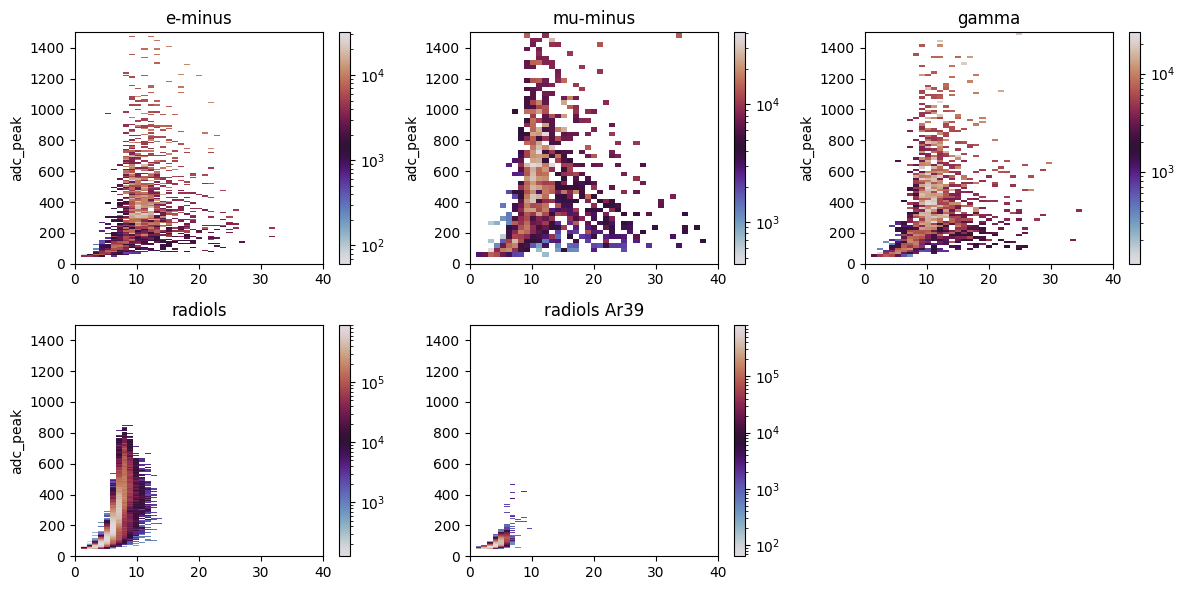

In [19]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2,3, figsize=(12,6))

size=1
x_name='samples_over_threshold'
x_range  = 0,40
y_name='adc_peak'
y_range  = 0,1500
cmap='twilight'
weights = 'adc_integral'
cut=''
v = 0

# dataset_sel['e-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='red')
# dataset_sel['mu-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='green')
# dataset_sel['gamma'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='orange')
# dataset_sel['radiols'].sig_view_2.query('bt_generator_name != "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='green')
# dataset_sel['radiols'].sig_view_2.query('bt_generator_name == "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='blue')


# ----
sample='e-minus'
ax = axes[0][0]
df = dataset_sel[sample].sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='mu-minus'
ax = axes[0][1]
df = dataset_sel[sample].sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='gamma'
ax = axes[0][2]
df = dataset_sel['gamma'].sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='radiols'
ax = axes[1][0]
df = dataset_sel[sample].query('bt_generator_name != "Ar39GenInLAr"').sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='radiols'
ax = axes[1][1]
df = dataset_sel[sample].query('bt_generator_name == "Ar39GenInLAr"').sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample+' Ar39')
ax.set_ylim(y_range)
ax.set_xlim(x_range)

# ----
# remove the underlying axes
axes[1,2].remove()

fig.tight_layout()
# fig.show()





In [155]:
print(make_rates_table(datasets, f'bt_is_signal == 0 & {safe_samples_cut}', ro_win_len=8000, title='noise TP rates'))
print(make_rates_table(datasets, f'bt_is_signal == 1 & {safe_samples_cut}', ro_win_len=8000, title='signal TP rates'))
print(make_rates_table(datasets, f'bt_is_signal == 0 & {safe_samples_cut}', ro_win_len=8000, title='noise TP rates'))
print(make_rates_table(datasets, f'bt_is_signal == 1 & {safe_samples_cut}', ro_win_len=8000, title='signal TP rates'))

                   noise TP rates                    
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time    ┃ U       ┃ V        ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 0.74 Hz │ 0.72 Hz  │ 0.30 Hz │
│ gamma    │ 0.400 s │ 0.74 Hz │ 0.72 Hz  │ 0.30 Hz │
│ mu-minus │ 0.400 s │ 0.71 Hz │ 0.73 Hz  │ 0.32 Hz │
│ ar39     │ 0.400 s │ 0.94 Hz │ 2.17 Hz  │ 0.42 Hz │
│ radiols  │ 0.400 s │ 9.81 Hz │ 14.60 Hz │ 3.97 Hz │
└──────────┴─────────┴─────────┴──────────┴─────────┘

                    signal TP rates                    
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ sample   ┃ time    ┃ U        ┃ V        ┃ X        ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 0.42 Hz  │ 0.38 Hz  │ 0.47 Hz  │
│ gamma    │ 0.400 s │ 0.36 Hz  │ 0.35 Hz  │ 0.43 Hz  │
│ mu-minus │ 0.400 s │ 0.33 Hz  │ 0.33 Hz  │ 0.39 Hz  │
│ ar39     │ 0.400 s │ 20.85 Hz │ 10.08 Hz │ 32.97 Hz │
│ radiols  │ 0.400 s │ 54.30 Hz │ 32.07 Hz │ 76.66 Hz │
└──────────┴─────────┴──────────┴──────────┴──────────┘

                   noise TP rates                    
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ sample   ┃ time    ┃ U       ┃ V        ┃ X       ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 0.74 Hz │ 0.72 Hz  │ 0.30 Hz │
│ gamma    │ 0.400 s │ 0.74 Hz │ 0.72 Hz  │ 0.30 Hz │
│ mu-minus │ 0.400 s │ 0.71 Hz │ 0.73 Hz  │ 0.32 Hz │
│ ar39     │ 0.400 s │ 0.94 Hz │ 2.17 Hz  │ 0.42 Hz │
│ radiols  │ 0.400 s │ 9.81 Hz │ 14.60 Hz │ 3.97 Hz │
└──────────┴─────────┴─────────┴──────────┴─────────┘

                    signal TP rates                    
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ sample   ┃ time    ┃ U        ┃ V        ┃ X        ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ e-minus  │ 0.400 s │ 0.42 Hz  │ 0.38 Hz  │ 0.47 Hz  │
│ gamma    │ 0.400 s │ 0.36 Hz  │ 0.35 Hz  │ 0.43 Hz  │
│ mu-minus │ 0.400 s │ 0.33 Hz  │ 0.33 Hz  │ 0.39 Hz  │
│ ar39     │ 0.400 s │ 20.85 Hz │ 10.08 Hz │ 32.97 Hz │
│ radiols  │ 0.400 s │ 54.30 Hz │ 32.07 Hz │ 76.66 Hz │
└──────────┴─────────┴──────────┴──────────┴──────────┘

# Impact of Ar39 rejection cut 

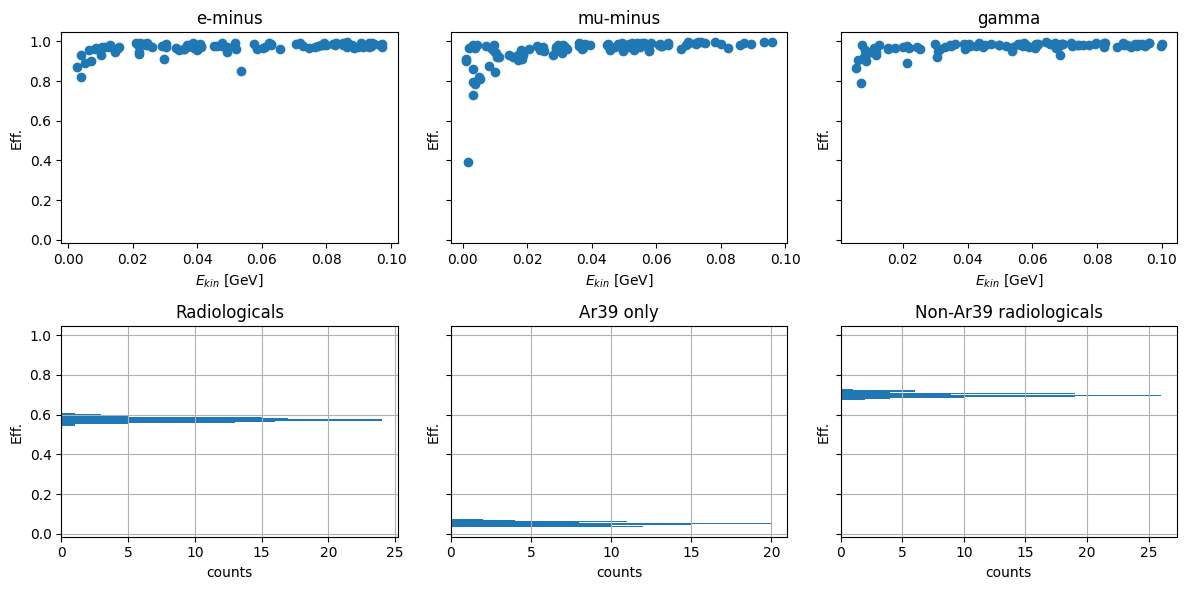

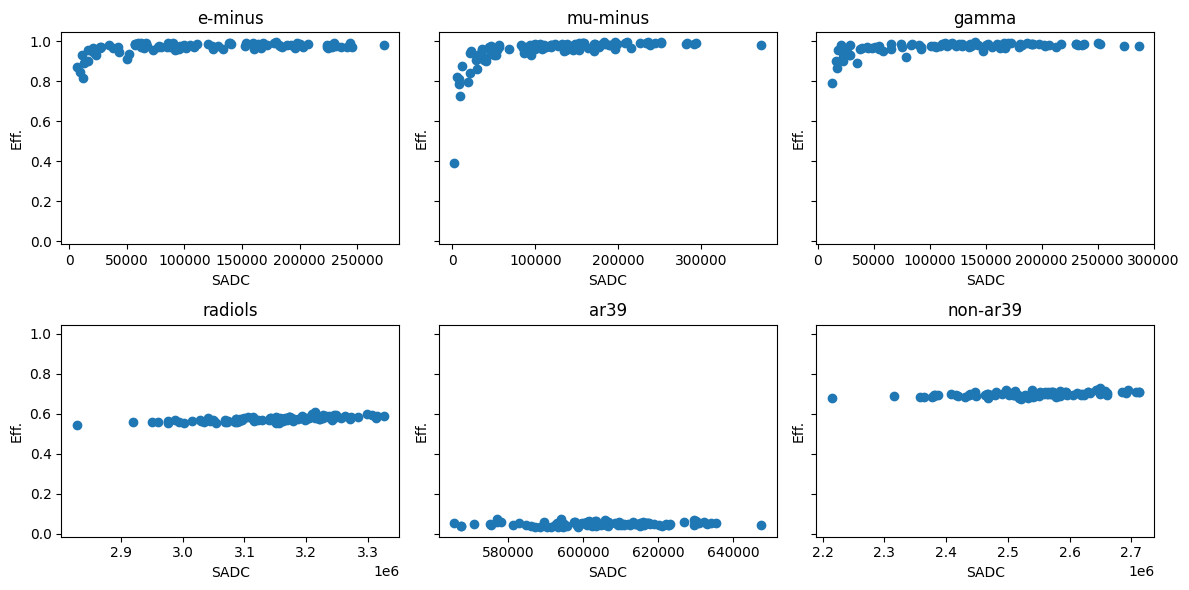

In [95]:
# Copy dataset_sel and add ar39 and non-ar39 rads
dss = dataset_sel.copy()
dss['ar39'] = dss['radiols'].query('bt_generator_name == "Ar39GenInLAr"')
dss['non-ar39'] = dss['radiols'].query('bt_generator_name != "Ar39GenInLAr"')


fig, axes = plt.subplots(2,3, figsize=(12,6), sharey=True)

sample='e-minus'
cut='samples_over_threshold>8'
v=2

def plot_ratio_ekin(ax, sample):
    
    ds = dataset_sel[sample]
    sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
    sum_adc_filtered = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())

    ek = datasets[sample].mctruths.kinetic_energy

    ax.scatter(x=ek, y=sum_adc_filtered/sum_adc_total)
    ax.set_title(sample)
    ax.set_ylabel("Eff.")
    ax.set_xlabel("$E_{kin}$ [GeV]")


def plot_eff_hist():
    pass

def plot_ratio_sadc(ax, sample):
    ds = dss[sample]
    sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
    sum_adc_filtered = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())

    ax.scatter(x=sum_adc_total, y=sum_adc_filtered/sum_adc_total)
    ax.set_title(sample)
    ax.set_ylabel("Eff.")
    ax.set_xlabel("SADC")

plot_ratio_ekin(axes[0,0],'e-minus')
plot_ratio_ekin(axes[0,1],'mu-minus')
plot_ratio_ekin(axes[0,2],'gamma')
# plot_me(axes[1,0],'radiols')

#---
ax=axes[1,0]
sample='radiols'
ds = dataset_sel[sample]

sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
y = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())
(y/sum_adc_total).hist(ax=ax, orientation="horizontal")
ax.set_title("Radiologicals")
ax.set_xlabel("counts")
ax.set_ylabel("Eff.")


#---
ax=axes[1,1]
sample='radiols'
ds = dataset_sel[sample].query('bt_generator_name == "Ar39GenInLAr"')

sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
y = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())
(y/sum_adc_total).hist(ax=ax,orientation="horizontal")
ax.set_title("Ar39 only")
ax.set_xlabel("counts")
ax.set_ylabel("Eff.")

#---
ax=axes[1,2]
sample='radiols'
ds = dataset_sel[sample].query('bt_generator_name != "Ar39GenInLAr"')

sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
y = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())
(y/sum_adc_total).hist(ax=ax, orientation="horizontal")
ax.set_title("Non-Ar39 radiologicals")
ax.set_xlabel("counts")
ax.set_ylabel("Eff.")

# axes[1,1].remove()
# axes[1,2].remove()


fig.tight_layout()


fig, axes = plt.subplots(2,3, figsize=(12,6), sharey=True)
plot_ratio_sadc(axes[0,0],'e-minus')
plot_ratio_sadc(axes[0,1],'mu-minus')
plot_ratio_sadc(axes[0,2],'gamma')
plot_ratio_sadc(axes[1,0],'radiols')
plot_ratio_sadc(axes[1,1],'ar39')
plot_ratio_sadc(axes[1,2],'non-ar39')
fig.tight_layout()


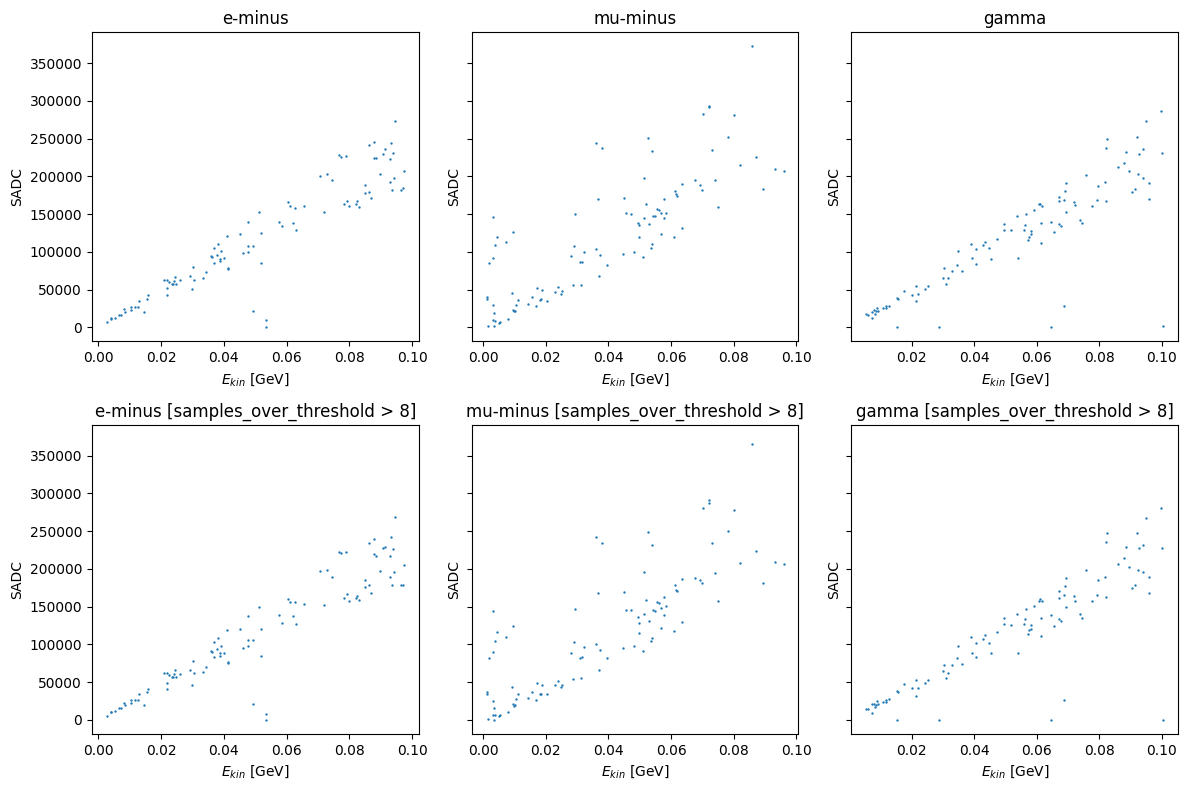

In [145]:
# Copy dataset_sel and add ar39 and non-ar39 rads
dss = dataset_sel.copy()
# dss['ar39'] = dss['radiols'].query('bt_generator_name == "Ar39GenInLAr"')
# dss['non-ar39'] = dss['radiols'].query('bt_generator_name != "Ar39GenInLAr"')


fig, axes = plt.subplots(2,3, figsize=(12,8), sharey=True)

sample='e-minus'
cut='samples_over_threshold>8'
v=2

def plot_adcint_ekin(ax, sample, cut: str=None):
    
    ds = dataset_sel[sample]
    if cut:
        ds=ds.query(cut)
    adcint_ev = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
    # print("adcint>>\n", adcint_ev)
    # print("adcint>>\n", adcint_ev.to_frame())
    # print(len(datasets[sample].mctruths))
    # print(len(datasets[sample].mctruths.event))

    # ek = datasets[sample].mctruths.kinetic_energy
    df = datasets[sample].mctruths[['event', 'kinetic_energy']]
    df = df.join(adcint_ev.to_frame(), on='event', how='outer').fillna(0)
    # print("c\n\n",c)
    ax.scatter(x=df.kinetic_energy, y=df.adc_integral, s=0.5)
    ax.set_title(sample + (f' [{cut}]' if cut else ''))
    ax.set_ylabel("SADC")
    ax.set_xlabel("$E_{kin}$ [GeV]")


plot_adcint_ekin(axes[0,0], 'e-minus')
plot_adcint_ekin(axes[0,1], 'mu-minus')
plot_adcint_ekin(axes[0,2], 'gamma')


plot_adcint_ekin(axes[1,0], 'e-minus', cut='samples_over_threshold > 8')
plot_adcint_ekin(axes[1,1], 'mu-minus', cut='samples_over_threshold > 8')
plot_adcint_ekin(axes[1,2], 'gamma', cut='samples_over_threshold > 8')
fig.tight_layout()